In [393]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

At first let's perform some EDA and DQC

In [342]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
holidays_events_data = pd.read_csv('holidays_events.csv')
oil_data = pd.read_csv('oil.csv')
stores_data = pd.read_csv('stores.csv')
transactions_data = pd.read_csv('transactions.csv')

In [343]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [344]:
train_data.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [345]:
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [346]:
train_data.duplicated().sum()

0

In [347]:
train_data.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [348]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [349]:
len(train_data)

3000888

In [350]:
len(test_data)

28512

In [351]:
train_data.duplicated().sum()

0

In [352]:
holidays_events_data.duplicated().sum()

0

In [353]:
oil_data.duplicated().sum()

0

In [354]:
holidays_events_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [355]:
holidays_events_data['priority'] = holidays_events_data['locale'].map({'National': 3, 'Regional': 2, 'Local': 1})
holidays_events_data = holidays_events_data.sort_values(by=['date', 'priority'], ascending=False)
holidays_events_data = holidays_events_data.drop_duplicates(subset=['date'], keep='first')
holidays_events_data.drop('priority', axis=1, inplace=True)

In [356]:
holidays_events_data[pd.to_datetime(holidays_events_data['date']) == pd.to_datetime('2013-06-25')]

,date,type,locale,locale_name,description,transferred
58,2013-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False


In [357]:
def merge_data(data):
    #data = pd.merge(data, transactions_data, on=['date', 'store_nbr'], how='inner')  !Some questions about this dataset appeared
    data = pd.merge(data, stores_data, on=['store_nbr'], how='inner')
    data = pd.merge(data, oil_data, on=['date'], how='left')
    data = pd.merge(data, holidays_events_data, on=['date'], how='left')   # Длина train_data увеличилась что странно, надо смотреть почему
    
    data.fillna({'type_y': 'Not holiday', 'locale': 'Not holiday', 'locale_name' : 'Not holiday', 'description' : 'Not holiday',
                         'transferred' : 'Not holiday'}, inplace=True)

    data.rename(columns={'store_nbr' : 'store_number', 'type_x': 'store_type', 'cluster' : 'store_cluster',
                        'dcoilwtico' : 'oil_price', 'locale' : 'holiday_status', 'locale_name' : 'holiday_location',
                        'description' : 'holiday_description', 'type_y' : 'day_type', 'transferred' : 'is_holiday_transferred',
                        'family' : 'item_family', 'sales' : 'item_sales', 'onpromotion' : 'items_on_promotion'}, inplace=True)
    data['date'] = pd.to_datetime(data['date'])  
    data.set_index('date', inplace=True)
    data.drop(['id'], axis=1, inplace=True)
    data['oil_price'].bfill(inplace=True)
    data = data.sort_index()
    return data


In [358]:
train_data = merge_data(train_data)
test_data = merge_data(test_data)

/var/folders/sv/rfynv7hs7_ndkp9bwt1tr_t40000gn/T/ipykernel_7305/997419944.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/sv/rfynv7hs7_ndkp9bwt1tr_t40000gn/T/ipykernel_7305/997419944.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df

In [359]:
train_data.head()

,store_number,item_family,item_sales,items_on_promotion,city,state,store_type,store_cluster,oil_price,day_type,holiday_status,holiday_location,holiday_description,is_holiday_transferred
date,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False


In [360]:
test_data.head()

,store_number,item_family,items_on_promotion,city,state,store_type,store_cluster,oil_price,day_type,holiday_status,holiday_location,holiday_description,is_holiday_transferred
date,,,,,,,,,,,,,
2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8,Not holiday,Not holiday,Not holiday,Not holiday,Not holiday
2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.8,Not holiday,Not holiday,Not holiday,Not holiday,Not holiday
2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.8,Not holiday,Not holiday,Not holiday,Not holiday,Not holiday
2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8,Not holiday,Not holiday,Not holiday,Not holiday,Not holiday
2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.8,Not holiday,Not holiday,Not holiday,Not holiday,Not holiday


In [361]:
train_data.isna().sum()

store_number              0
item_family               0
item_sales                0
items_on_promotion        0
city                      0
state                     0
store_type                0
store_cluster             0
oil_price                 0
day_type                  0
holiday_status            0
holiday_location          0
holiday_description       0
is_holiday_transferred    0
dtype: int64

In [362]:
test_data.isna().sum()

store_number              0
item_family               0
items_on_promotion        0
city                      0
state                     0
store_type                0
store_cluster             0
oil_price                 0
day_type                  0
holiday_status            0
holiday_location          0
holiday_description       0
is_holiday_transferred    0
dtype: int64

In [363]:
len(train_data)

3000888

In [364]:
len(test_data)

28512

So we see that the lengths of the datasets are same as they were before the preprocessing

In [365]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 14 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   store_number            int64  
 1   item_family             object 
 2   item_sales              float64
 3   items_on_promotion      int64  
 4   city                    object 
 5   state                   object 
 6   store_type              object 
 7   store_cluster           int64  
 8   oil_price               float64
 9   day_type                object 
 10  holiday_status          object 
 11  holiday_location        object 
 12  holiday_description     object 
 13  is_holiday_transferred  object 
dtypes: float64(2), int64(3), object(9)
memory usage: 343.4+ MB


In [366]:
train_data[train_data['item_sales'] != 0]['item_family'].value_counts()

item_family
BREAD/BAKERY                  83606
BEVERAGES                     83605
MEATS                         83605
CLEANING                      83605
DAIRY                         83605
DELI                          83605
EGGS                          83605
GROCERY I                     83604
PERSONAL CARE                 83602
POULTRY                       83592
PREPARED FOODS                83585
FROZEN FOODS                  83578
GROCERY II                    79921
AUTOMOTIVE                    79310
LINGERIE                      76344
LIQUOR,WINE,BEER              74690
SEAFOOD                       73332
BEAUTY                        67036
PRODUCE                       65151
HOME AND KITCHEN I            59431
HOME AND KITCHEN II           59369
HOME CARE                     53735
CELEBRATION                   51257
PLAYERS AND ELECTRONICS       50118
LAWN AND GARDEN               48392
HARDWARE                      47412
PET SUPPLIES                  41271
MAGAZINES       

In [367]:
len(train_data['item_family'].unique())

33

In [368]:
train_data['city'].unique()

array(['Quito', 'Cayambe', 'Latacunga', 'Riobamba', 'Ibarra',
       'Santo Domingo', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil',
       'Salinas', 'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad',
       'Cuenca', 'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [369]:
train_data['state'].unique()

array(['Pichincha', 'Cotopaxi', 'Chimborazo', 'Imbabura',
       'Santo Domingo de los Tsachilas', 'Bolivar', 'Pastaza',
       'Tungurahua', 'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja',
       'El Oro', 'Esmeraldas', 'Manabi'], dtype=object)

In [370]:
sorted(train_data['store_number'].unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54]

In [371]:
train_data['store_type'].unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

In [372]:
sorted(train_data['store_cluster'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [373]:
train_data['day_type'].unique()

array(['Holiday', 'Not holiday', 'Work Day', 'Additional', 'Event',
       'Transfer', 'Bridge'], dtype=object)

In [374]:
train_data['holiday_status'].unique()

array(['National', 'Not holiday', 'Local', 'Regional'], dtype=object)

In [375]:
train_data['holiday_location'].unique()

array(['Ecuador', 'Not holiday', 'Manta', 'Cotopaxi', 'Cuenca',
       'Libertad', 'Riobamba', 'Guaranda', 'Imbabura', 'El Carmen',
       'Cayambe', 'Guayaquil', 'Esmeraldas', 'Ambato', 'Ibarra',
       'Quevedo', 'Santo Domingo de los Tsachilas', 'Santa Elena',
       'Latacunga', 'Quito', 'Loja', 'Puyo'], dtype=object)

In [376]:
len(train_data['holiday_description'].unique())

95

In [377]:
train_data['item_sales'].min()

0.0

In [378]:
train_data['item_sales'].max()

124717.0

In [379]:
train_data['item_sales'].mean()

357.77574911261894

In [380]:
train_data['item_sales'].median()

11.0

In [381]:
train_data[train_data['item_sales'] == train_data['item_sales'].max()]

,store_number,item_family,item_sales,items_on_promotion,city,state,store_type,store_cluster,oil_price,day_type,holiday_status,holiday_location,holiday_description,is_holiday_transferred
date,,,,,,,,,,,,,,
2016-05-02,2,GROCERY I,124717.0,59,Quito,Pichincha,D,13,44.75,Event,National,Ecuador,Terremoto Manabi+16,False


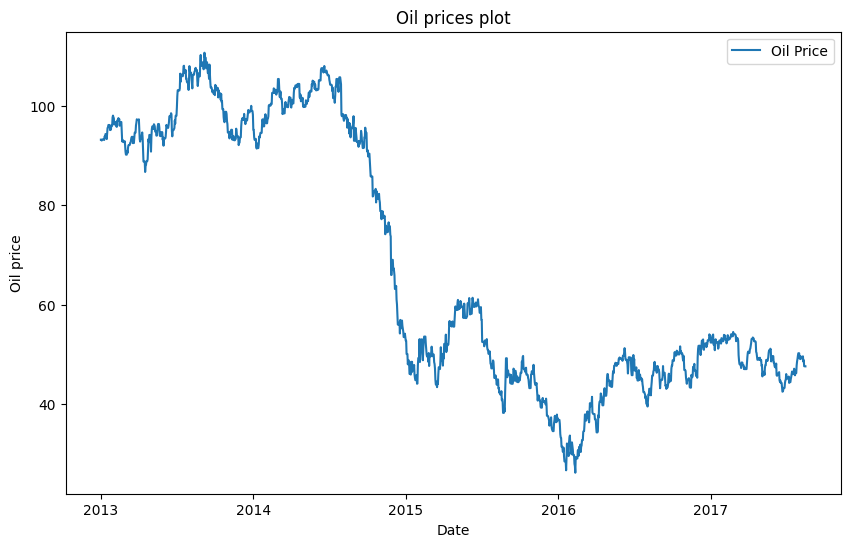

In [394]:
plt.figure(figsize=(10, 6))  
plt.plot(train_data.index, train_data['oil_price'], label='Oil Price')
plt.title('Oil prices plot')
plt.xlabel('Date')
plt.ylabel('Oil price')
plt.legend()
plt.show()

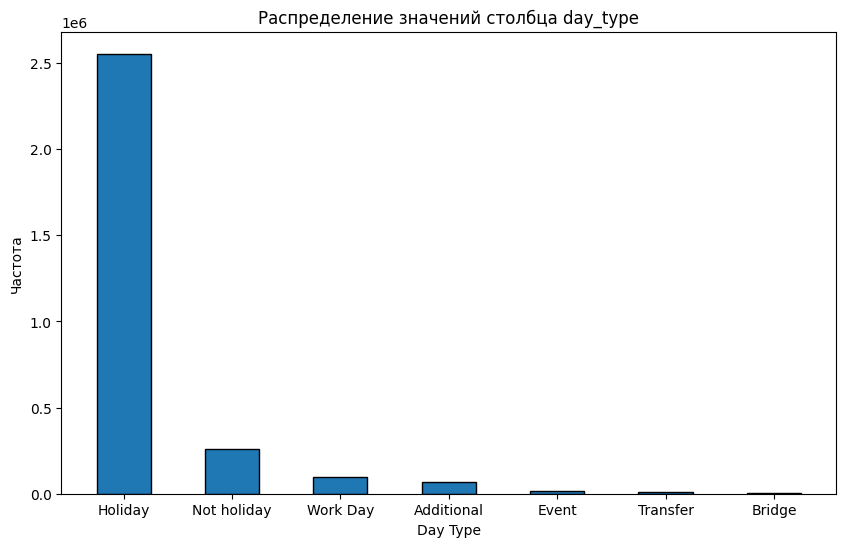

In [395]:
plt.figure(figsize=(10, 6))  
plt.bar(train_data['day_type'].unique(), train_data['day_type'].value_counts(), width=0.5, edgecolor='black')
plt.title('Распределение значений столбца day_type')
plt.xlabel('Day Type')
plt.ylabel('Частота')
plt.show()